In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from pathlib import Path

In [4]:
from xmen.evaluation import entity_linking_error_analysis, evaluate_at_k
from xmen.linkers.util import filter_and_apply_threshold

In [5]:
from xmen.confhelper import load_config
config = load_config('../conf/distemist.yaml')
base_path = Path(config.cache_dir)
tmp_path = Path('..') / 'temp'

In [6]:
import datasets

ds = datasets.load_dataset('distemist', 'distemist_linking_bigbio_kb')

# Own validation set (20% of distemist training set / EL sub-track)
with open('distemist_validation_docs.txt', 'r') as fh:
    valid_ids = [l.strip() for l in fh.readlines()]
    
ds_train = ds['train'].filter(lambda d: d['document_id'] not in valid_ids)
ds_valid = ds['train'].filter(lambda d: d['document_id'] in valid_ids)

ds['train'] = ds_train
ds['validation'] = ds_valid

ds

Using the latest cached version of the module from /home/Florian.Borchert/.cache/huggingface/modules/datasets_modules/datasets/distemist/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd (last modified on Thu Apr 20 13:14:35 2023) since it couldn't be found locally at distemist., or remotely on the Hugging Face Hub.
Found cached dataset distemist (/home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-c51f74b0be31bc1c.arrow
Loading cached processed dataset at /home/Florian.Borchert/.cache/huggingface/datasets/distemist/distemist_linking_bigbio_kb/1.0.0/f63b2c6775932c342d7bff59d751d6139c0c52c5255f7fbb3e458d255728a8dd/cache-2b861d41b461ff1b.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 466
    })
    test: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 117
    })
})

# Preparation - Just run once

__Note__: This is a bit more involved, because we dynamically explore different combinations of DisTEMIST gazetteer and UMLS subsets.

In most normal cases, you just want to configure the target dictionary in your .yaml file and run `xmen dict` and `xmen index` with default settings.

## Download Distemist gazetteer

In [ ]:
!mkdir -p ../temp; wget https://zenodo.org/record/6505583/files/dictionary_distemist.tsv?download=0 -O ../temp/dictionary_distemist.tsv

## Setup dictionaries

Since the DisTEMIST Task only covers a subset of SNOMED CT codes, we retrieve only additional synonyms for the UMLS for these codes.
Thus, we need to map CUIs to SNOMED CT IDs and merge them with the DisTEMIST gazetteer.

In [ ]:
dict_configs = ['distemist_gazetteer', 'distemist_umls_es', 'distemist_umls_en_es', 'distemist_umls_all'] 

In [ ]:
from IPython.display import Markdown, display

# Run these commands from the root folder
for d in dict_configs:
    display(Markdown(f"`xmen dict conf/distemist.yaml --code dicts/distemist.py --key {d}`"))

In [ ]:
meta_path = Path(config.umls_meta_path)

In [ ]:
from xmen.umls import umls_utils
from collections import defaultdict
from tqdm.auto import tqdm

def read_cui2snomed_mapping(meta_path):
    mrconso = 'MRCONSO.RRF'
    cui2snomed = defaultdict(list)
    headers = umls_utils.read_umls_file_headers(meta_path, mrconso)
    with open(f"{meta_path}/{mrconso}") as fin:
        for line in tqdm(fin.readlines()):
            splits = line.strip().split("|")
            assert len(headers) == len(splits)
            concept = dict(zip(headers, splits))
            if concept['SAB'] in ['SNOMEDCT_US', 'SCTSPA']:
                cui2snomed[concept['CUI']].append(concept['SCUI'])
    return cui2snomed

In [ ]:
cui2snomed_mapping = read_cui2snomed_mapping(meta_path)

In [ ]:
import json
from tqdm.auto import tqdm
from xmen.knowledge_base import CompositeKnowledgebase

def cui2snomed(entry):
    res = []
    cui = entry['concept_id']
    for sctid in cui2snomed_mapping[cui]:
        r = entry.copy()
        r['concept_id'] = sctid
        res.append(r)
    return res

def merge_and_write_dicts(target_jsonl, added_jsonl, output_jsonl):
    print(f'Writing to {output_jsonl}')
    output_jsonl.parent.mkdir(exist_ok=True, parents=True)
    cui_count = alias_count = 0
    kb = CompositeKnowledgebase([added_jsonl], mappers=[cui2snomed])
    with open(output_jsonl, 'w') as fo:
        for l in tqdm(list(open(target_jsonl).readlines())):
            cui_count += 1
            entry = json.loads(l)
            sctid = str(entry['concept_id'])
            concept = kb.cui_to_entity[sctid]
            known_aliases = [entry['canonical_name']] + entry['aliases']
            new_aliases = [c for c in [concept.canonical_name] + concept.aliases if c not in known_aliases]
            entry['aliases'] += new_aliases
            alias_count += len(entry['aliases'])
            fo.write(json.dumps(entry) + '\n')
    print(f'Written {cui_count} concepts with {alias_count} aliases')

In [ ]:
for d in dict_configs[1:]:
    merge_and_write_dicts(distemist_gazetteer_jsonl, base_path / d / f'{d}.jsonl', base_path / 'distemist' / 'merged' / f'{d}.jsonl')

## Prepare TF-IDF NGram and SapBERT indices for all configurations

In [ ]:
# Run these commands from the root folder
display(Markdown(f"`xmen index conf/distemist.yaml --dict {base_path / 'distemist_gazetteer' / 'distemist_gazetteer.jsonl'} --output {base_path / 'distemist' / 'merged' / 'distemist_gazetteer'} --all`"))
for d in dict_configs[1:]:
    display(Markdown(f"`xmen index conf/distemist.yaml --dict {base_path / 'distemist' / 'merged' / f'{d}.jsonl'} --output {base_path / 'distemist' / 'merged' / f'{d}'} --all`"))

# Candidate Generation

In [10]:
embedding_model_name = 'cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR'
dict_config = 'distemist_umls_en_es'

In [11]:
from notebook_util import analyze
from xmen.linkers import TFIDFNGramLinker, SapBERTLinker, EnsembleLinker
from xmen.linkers.util import filter_and_apply_threshold
from datasets import DatasetDict

In [12]:
index_base_path = base_path / 'distemist' / 'merged' / dict_config / 'index'

#### TF-IDF over character n-grams

In [16]:
ngram_linker = TFIDFNGramLinker(index_base_path=index_base_path / 'ngrams', k=100)
pred_ngram = ngram_linker.predict_batch(ds)
pred_ngram.save_to_disk(tmp_path / dict_config / 'pred_ngram')

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/466 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117 [00:00<?, ? examples/s]

In [17]:
_ = evaluate_at_k(ds['validation'], pred_ngram['validation'])

Perf@1 0.28599801390268126
Perf@2 0.4141012909632572
Perf@4 0.5858987090367428
Perf@8 0.6732869910625621
Perf@16 0.7209533267130089
Perf@32 0.7616683217477657
Perf@64 0.7974180734856008


#### Dense Retrieval with SapBERT

In [18]:
# Clear singleton to free up memory
SapBERTLinker.clear()
# Initialize linker from config
sapbert_linker = SapBERTLinker(
    embedding_model_name = embedding_model_name,
    index_base_path = index_base_path / 'sapbert',
    k = 1000
)

pred_sapbert = sapbert_linker.predict_batch(ds, batch_size=128)
pred_sapbert.save_to_disk(tmp_path / dict_config / 'pred_sapbert')

[05/08/23 19:13:30] INFO     Loading hierarchical faiss index                                ]8;id=319479;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=815753;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/sap_bert_linker.py#116\116]8;;\

                    INFO     Loading index from                                                 ]8;id=375339;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=387763;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/faiss_indexer.py#73\73]8;;\
                             /home/Florian.Borchert/.cache/xmen/distemist/merged/distemist_umls                    
                             _en_es/index/sapbert/embed_faiss_hier.pickle                                          

[05/08/23 19:13:32] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=622698;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=465372;file:///mnt/nfs/home/Florian.Borchert/workspace/xmen/notebooks/../xmen/linkers/faiss_indexer.py#75\75]8;;\
                             size 1518833                                                                          

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/466 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117 [00:00<?, ? examples/s]

In [19]:
_ = evaluate_at_k(ds['validation'], pred_sapbert['validation'])

Perf@1 0.3634558093346574
Perf@2 0.5243296921549155
Perf@4 0.6593843098311817
Perf@8 0.7437934458788481
Perf@16 0.7864945382323734
Perf@32 0.8083416087388282
Perf@64 0.8262164846077458


#### Ensemble

In [20]:
ensemble_linker = EnsembleLinker()
ensemble_linker.add_linker('sapbert', sapbert_linker, k=100)
ensemble_linker.add_linker('ngram', ngram_linker, k=100)

# Re-use predictions for efficiency
# TODO: reuse_preds currently does not work with dataset dicts
pred_ensemble = DatasetDict()
pred_ensemble['train'] = ensemble_linker.predict_batch(ds['train'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['train'], 'ngram' : pred_ngram['train']})
pred_ensemble['validation'] = ensemble_linker.predict_batch(ds['validation'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['validation'], 'ngram' : pred_ngram['validation']})
pred_ensemble['test'] = ensemble_linker.predict_batch(ds['test'], 128, 100, reuse_preds={'sapbert' : pred_sapbert['test'], 'ngram' : pred_ngram['test']})

pred_ensemble.save_to_disk(tmp_path / dict_config / 'pred_ensemble')

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/466 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/117 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/250 [00:00<?, ? examples/s]

In [21]:
_ = evaluate_at_k(ds['validation'], pred_ensemble['validation'])

Perf@1 0.4270109235352532
Perf@2 0.5412115193644489
Perf@4 0.660377358490566
Perf@8 0.7487586891757696
Perf@16 0.7954319761668321
Perf@32 0.8152929493545183
Perf@64 0.8411122144985105


# Reranking

In [7]:
from xmen.reranking.cross_encoder import CrossEncoderReranker, CrossEncoderTrainingArgs

In [8]:
K_RERANKING = 64
CONTEXT_LENGTH = 128
CROSS_ENC_MODEL = 'PlanTL-GOB-ES/roberta-base-biomedical-clinical-es'
NUM_EPOCHS = 20
SEM_TYPE=True

## Prepare Data for Cross-Encoder Training

In [28]:
# Dictionary used for entity representation
dict_config_rr = 'distemist_umls_es'

In [13]:
from xmen.linkers.util import filter_and_apply_threshold

candidates = datasets.load_from_disk(tmp_path / dict_config / 'pred_ensemble')
candidates = filter_and_apply_threshold(candidates, K_RERANKING, 0.0)

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [27]:
from xmen.knowledge_base import load_kb
#kb = load_kb(base_path / 'distemist_gazetteer' / 'distemist_gazetteer.jsonl')
kb = load_kb(base_path / 'distemist' / 'merged' / f'{dict_config_rr}.jsonl')

In [36]:
cross_enc_ds = CrossEncoderReranker.prepare_data(candidates, ds, kb, CONTEXT_LENGTH, encode_sem_type=SEM_TYPE)
cross_enc_ds.save_to_disk(tmp_path / f'cross_enc_ds_{dict_config_rr}')

Context length: 128


  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/4180 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

  0%|          | 0/2598 [00:00<?, ?it/s]

## Train Cross Encoder

In [29]:
from xmen.data.indexed_dataset import IndexedDatasetDict
cross_enc_ds = IndexedDatasetDict.load_from_disk(tmp_path / f'cross_enc_ds_{dict_config_rr}')
cross_enc_ds

{'train': [4180 items], 'validation': [956 items], 'test': [2598 items]}

In [40]:
cross_enc_ds['train'].dataset[0][0:10]

[<ScoredInputExample> label: 0, score: 0.6854951977729797, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice cecal con signos inflamatorios [END] 
 
 ; disorder [TYPE] inflamación de apéndice epiploico [TITLE] inflamación de apéndice epiploico (trastorno) [SEP] Apendicitis epiploica,
 <ScoredInputExample> label: 0, score: 0.6809297800064087, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice cecal con signos inflamatorios [END] 
 
 ; disorder [TYPE] apendicitis crónica [TITLE] inflamación crónica del apéndice [SEP] apendicitis crónica (trastorno) [SEP] Apendicitis crónica,
 <ScoredInputExample> label: 0, score: 0.6728464961051941, texts:  dado de alta a los diez días de la intervención quirúrgica.
 El estudio anatomopatológico del apéndice cecal fue informado como  [START] apéndice 

In [41]:
train_args = CrossEncoderTrainingArgs(
    CROSS_ENC_MODEL, 
    NUM_EPOCHS,
    score_regularization=True,
)

In [24]:
rr = CrossEncoderReranker()
output_dir = f'{tmp_path}/cross_encoder_training/'

In [ ]:
rr.fit(cross_enc_ds['train'].dataset, cross_enc_ds['validation'].dataset, output_dir=output_dir, training_args=train_args)

## Predict on Test Set

In [25]:
rr = CrossEncoderReranker.load(output_dir, device=0)

In [47]:
cross_enc_pred = rr.rerank_batch(candidates['test'], cross_enc_ds['test'])

Batches:   0%|          | 0/2598 [00:00<?, ?it/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [49]:
_ = evaluate_at_k(ds['test'], cross_enc_pred)

Perf@1 0.5886472539624032
Perf@2 0.6634721710283819
Perf@4 0.7121267969037965
Perf@8 0.7419830446000737
Perf@16 0.7736822705492076
Perf@32 0.7869517139697751
Perf@64 0.7976409878363435


In [30]:
cross_enc_pred_valid = rr.rerank_batch(candidates['validation'], cross_enc_ds['validation'])

Batches:   0%|          | 0/956 [00:00<?, ?it/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

In [31]:
_ = evaluate_at_k(ds['validation'], cross_enc_pred_valid)

Perf@1 0.6246276067527309
Perf@2 0.6931479642502483
Perf@4 0.7656405163853028
Perf@8 0.791459781529295
Perf@16 0.8093346573982125
Perf@32 0.8291956305858987
Perf@64 0.8411122144985105


# Error Analysis

In [32]:
from notebook_util import analyze
from xmen.knowledge_base import load_kb

In [33]:
cg_kb = load_kb(base_path / 'distemist' / 'merged' / f'{dict_config}.jsonl')

In [34]:
error_cand = entity_linking_error_analysis(ds['validation'], candidates['validation'])
edf_cand, _ = analyze(error_cand, cg_kb, 'eval', None)

In [35]:
# False negative (not part of top 64)
fns_cand = edf_cand[edf_cand.pred_index == -1]
fns_cand_counts = fns_cand.error_type.value_counts() / len(edf_cand)
fns_cand_counts

error_type
COMPLEX_ENTITY         0.116187
ABBREV                 0.021847
UNKNOWN_ERROR          0.010924
WRONG_SEMANTIC_TYPE    0.009930
Name: count, dtype: float64

In [36]:
# Ranking errors during candidate generation
misranked_cand = edf_cand[edf_cand.pred_index > 0]
misranked_cand_counts = misranked_cand.error_type.value_counts() / len(edf_cand)
misranked_cand_counts

error_type
COMPLEX_ENTITY         0.173784
WRONG_SEMANTIC_TYPE    0.119166
SAME_SYNONYMS          0.070506
UNKNOWN_ERROR          0.042701
ABBREV                 0.007944
Name: count, dtype: float64

In [38]:
# Ranking errors after reranking
error_rr = entity_linking_error_analysis(ds['validation'], cross_enc_pred_valid)
edf_rr, _ = analyze(error_rr, cg_kb, 'eval', None)

misranked_rr = edf_rr[edf_rr.pred_index > 0]
misranked_rr_counts = misranked_rr.error_type.value_counts() / len(edf_rr)
misranked_rr_counts

error_type
COMPLEX_ENTITY         0.123138
WRONG_SEMANTIC_TYPE    0.035750
SAME_SYNONYMS          0.026812
UNKNOWN_ERROR          0.023833
ABBREV                 0.006951
Name: count, dtype: float64

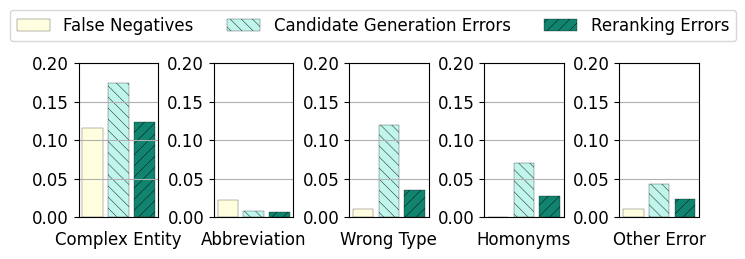

In [40]:
import matplotlib
from matplotlib import pyplot as plt

error_types = ['Complex Entity', 'Abbreviation', 'Wrong Type', 'Homonyms', 'Other Error']
keys = ['COMPLEX_ENTITY', 'ABBREV', 'WRONG_SEMANTIC_TYPE', 'SAME_SYNONYMS', 'UNKNOWN_ERROR']
counts = [fns_cand_counts, misranked_cand_counts, misranked_rr_counts]
count_names = ['False Negatives', 'Candidate Generation Errors', 'Reranking Errors']

hatches = ['', '\\\\\\', '///']
colors = ['lightyellow', '#C0F5EC', '#118470']

matplotlib.rcParams['hatch.linewidth'] = 0.3 
matplotlib.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(1, len(keys), figsize=(8, 2))
for i, (key, error) in enumerate(zip(keys, error_types)):
    for j, bar in enumerate(axs[i].bar(x=count_names, height=[c.get(key, 0.0) for c in counts], color=colors, edgecolor = 'black', linewidth=0.2)):
        bar.set_hatch(hatches[j])
    axs[i].grid(axis='y')
    axs[i].set_ylim([0.0, 0.2])
    axs[i].set_xlabel(error, labelpad=10)
    axs[i].get_xaxis().set_ticks([])
handles = [plt.Rectangle((0,0),1,1, facecolor=color, linewidth=0.2, edgecolor='black', hatch=h) for color, h in zip(colors, hatches)]
plt.legend(handles, count_names, loc='upper center', bbox_to_anchor=(-3.1, 1.4, 0, 0), ncol=len(counts))

plt.subplots_adjust(wspace=0.7)